In [33]:
from ptlpinns.odes import equations, numerical
from ptlpinns.models import model, transfer
import numpy as np
import time
import torch
from ptlpinns.perturbation import LPM, standard
import matplotlib.pyplot as plt

Note: computational time scales with N for PINNs but not for the numerical solvers

In [34]:
N_ITER = 25

N = 512
t_span = (0, 10)
t_eval = np.linspace(t_span[0], t_span[1], N)

RK45_time, Radau_time, PTL_PINN_inverting, PTL_PINN_not_inverting = [], [], [], []

In [35]:
zeta_list = [0, 0.5, 5]

w_list_transfer = [1, 1, 1]

forcing_names = ['']

def forcing(numpy=False):
    if not numpy:
        def force(t):
            return torch.stack((torch.zeros_like(t), torch.zeros_like(t)), dim=1)
    else:
        def force(t):
            return np.stack((np.zeros_like(t), np.zeros_like(t)), axis=1)
    return force

forcing_list = [forcing(True), forcing(True), forcing(True), forcing(True), forcing(True), forcing(True)]

def zeroes_1D(t):
    return np.zeros_like(t)

forcing_1D = [zeroes_1D, zeroes_1D, zeroes_1D]

ic_list = [[1, 0], [1, 0], [1, 0]]
p_list = [[0, 1, 2, 3, 4, 5], [0, 1, 2, 3, 4, 5], [0, 1, 2, 3, 4, 5]]
epsilon_list = [0.5, 0.5, 0.5]
q = [(3, 1)]

### RK45 and Radau times

In [36]:
RK45_solution = []

for i, zeta in enumerate(zeta_list):

    ode = equations.ode_oscillator_1D(w_0=w_list_transfer[i], zeta=zeta, forcing_1D=forcing_1D[i], q=q, epsilon=0.5)
    RK45_sol = numerical.solve_ode_equation(ode, t_span, t_eval, ic_list[i], method="RK45", rtol=1e-5, atol=1e-5)
    RK45_solution.append(RK45_sol[0, :])

### PTL-PINNs

In [37]:
undamped_path = "/home/dda24/PTL-PINNs/ptlpinns/models/train/undamped_k12"
undamped_name = "model_undamped_k12.pth"
undamped_model, _ = model.load_model(undamped_path, undamped_name)

underdamped_path = "/home/dda24/PTL-PINNs/ptlpinns/models/train/underdamped_k12"
underdamped_name = "model_underdamped_k12.pth"
underdamped_model, _ = model.load_model(underdamped_path, underdamped_name)

overdamped_path = "/home/dda24/PTL-PINNs/ptlpinns/models/train/overdamped_k12"
overdamped_name = "model_overdamped_k15.pth"
overdamped_model, _ = model.load_model(underdamped_path, underdamped_name)

12 True True True 1.0 16 [256, 256, 512]
12 True True True 1.0 16 [128, 128, 256]
12 True True True 1.0 16 [128, 128, 256]


In [38]:
# Compute latent representation: H(t) and derivatives
H_dict_undamped = transfer.compute_H_dict(undamped_model, N=N, bias=True, t_span=(t_span[0], t_span[1]))
H_dict_underdamped = transfer.compute_H_dict(underdamped_model, N=N, bias=True, t_span=(t_span[0], t_span[1]))
H_dict_overdamped = transfer.compute_H_dict(overdamped_model, N=N, bias=True, t_span=(t_span[0], t_span[1]))

training_log = {'w_ode': 1.5, 'w_ic': 1}

In [39]:
time_list, sol_list = [], []

for i in range(len(zeta_list)):

    print("solving for zeta =", zeta_list[i])

    time_zeta_list, sol_zeta_list = [], []

    for j in range(N_ITER):

        if zeta_list[i] == 0:
            solver = "LPM"
            H_dict = H_dict_undamped
        elif 0 < zeta_list[i] < 1:
            solver = "standard"
            H_dict = H_dict_underdamped
        else:
            solver = "standard"
            H_dict = H_dict_overdamped 

        _, _, _ = transfer.compute_perturbation_solution([w_list_transfer[i]], [zeta_list[i]], [epsilon_list[i]], p_list[i],
                                [ic_list[i]], [forcing_list[i]], H_dict,
                                t_eval, training_log, all_p=True, comp_time=True,
                                solver=solver, w_sol = [], invert=True)

        # invert = False
        NN_TL_solution, perturbation_solution, TL_time_not_inverting = transfer.compute_perturbation_solution([w_list_transfer[i]], [zeta_list[i]], [epsilon_list[i]], p_list[i],
                                                                [ic_list[i]], [forcing_list[i]], H_dict,
                                                                t_eval, training_log, all_p=True, comp_time=True,
                                                                solver=solver, w_sol = [], invert=False)
        
        time_zeta_list.append(TL_time_not_inverting)
        sol_zeta_list.append(NN_TL_solution.squeeze()[:, :, 0])

    time_list.append(time_zeta_list) # shape: (3, NITER, 6)
    sol_list.append(sol_zeta_list) # shape: (3, NITER, 6, 512)

solving for zeta = 0
solving for zeta = 0.5
solving for zeta = 5


In [40]:
# RK45_solution - shape: (3, 512)
# sol_list.append - shape: (3, NITER, 6, 512)

sol_list = np.array(sol_list)
RK45_solution = np.array(RK45_solution)
error = sol_list - RK45_solution[:, np.newaxis, np.newaxis, :]

error.shape

(3, 25, 6, 512)

In [41]:
NN_TL_solution.squeeze().shape

(6, 512, 2)

In [42]:
error = np.mean(error, axis = 1)
error.shape

(3, 6, 512)

In [43]:
error = np.abs(np.mean(error, axis = 2))
error.shape

(3, 6)

In [44]:
time_list = np.mean(time_list, axis=1)

/tmp/ipykernel_14896/1578983549.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis", mean_time_per_correction.shape[0])


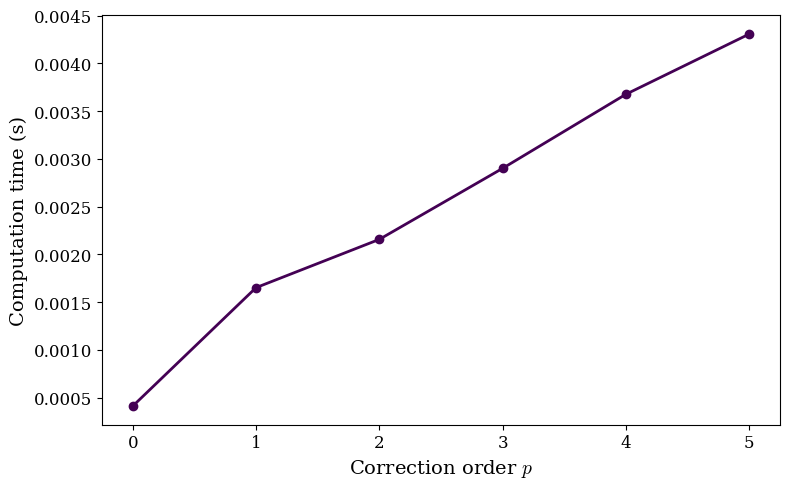

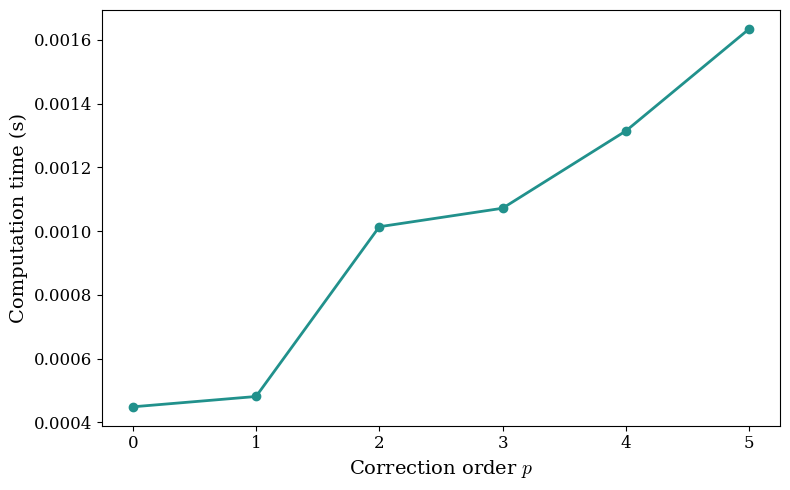

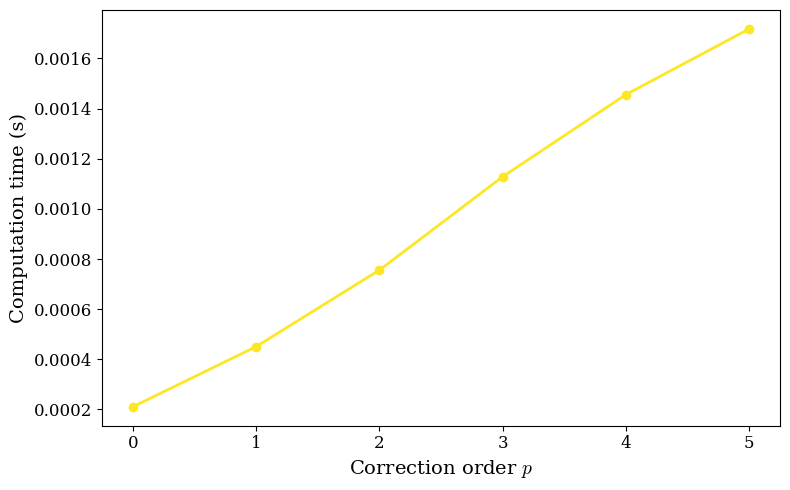

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["DejaVu Serif"],
    "mathtext.fontset": "cm",
    "text.usetex": False,
})

mean_time_per_correction = time_list

# --- Colormap ---
cmap = cm.get_cmap("viridis", mean_time_per_correction.shape[0])

# --- Loop over damping levels ---
for i in range(mean_time_per_correction.shape[0]):
    fig, ax = plt.subplots(figsize=(8, 5))

    base_color = cmap(i / (mean_time_per_correction.shape[0] - 1))
    rk_color   = base_color
    pinn_color = cm.viridis(0.1 + 0.8 * i / (mean_time_per_correction.shape[0] - 1))

    ax.plot(
        np.arange(mean_time_per_correction.shape[1]),
        mean_time_per_correction[i],
        marker='o',
        linewidth=2.0,
        color=base_color,
    )

    ax.set_xlabel("Correction order $p$", fontsize=14)
    ax.set_ylabel("Computation time (s)", fontsize=14)
    ax.tick_params(labelsize=12)
    plt.tight_layout()
    plt.show()


In [47]:
error = np.array([[0.59192, 0.05716, 0.015744, 0.00573, 0.00238, 0.00112], [0.1241, 0.0424, 0.0141, 0.0117, 0.0058, 0.0049], [0.0706, 0.0174, 0.0055, 0.0018, 0.0008, 0.0003]])

/tmp/ipykernel_14896/1953071541.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis", error.shape[0])


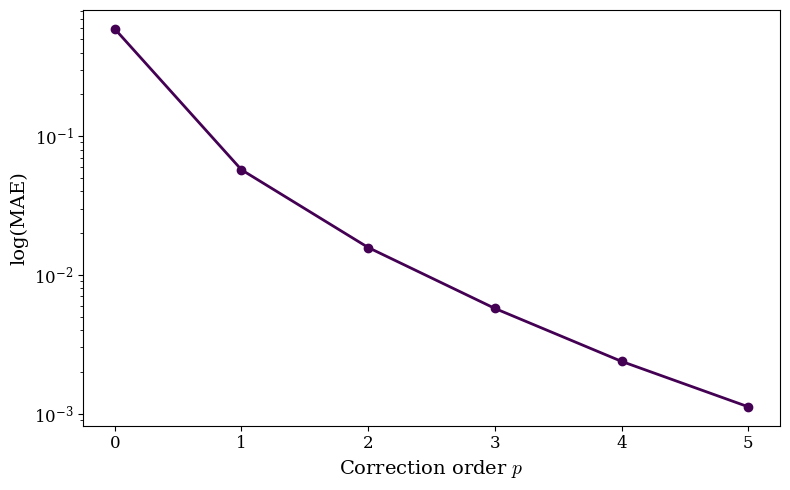

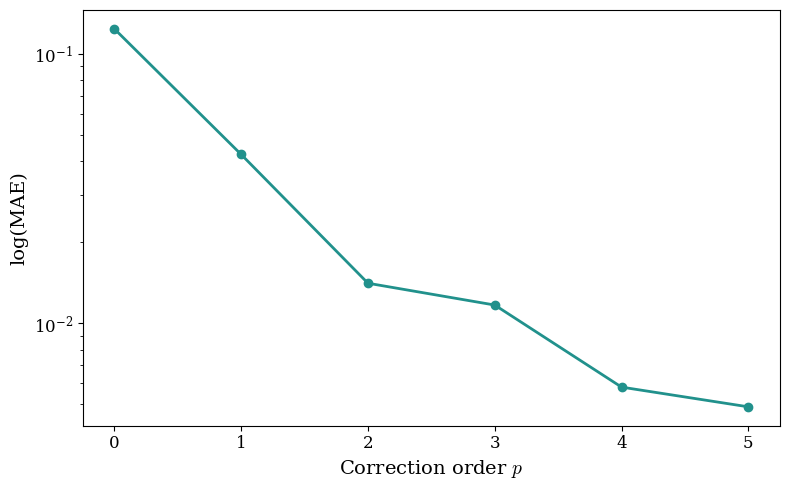

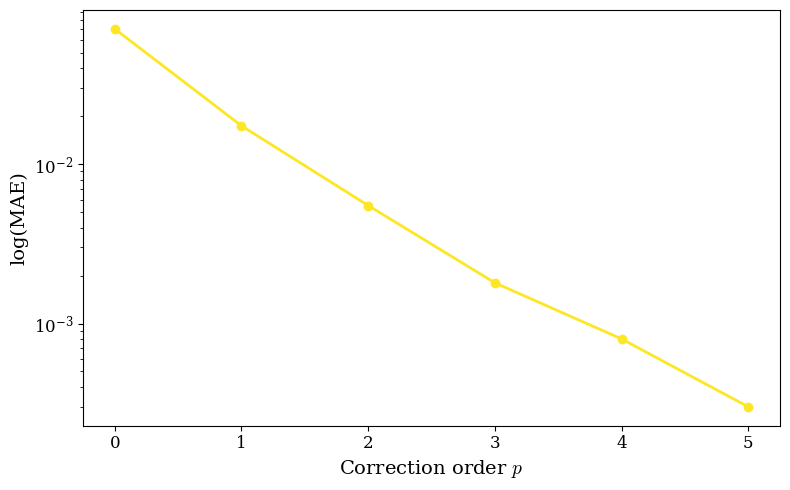

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# --- Colormap ---
cmap = cm.get_cmap("viridis", error.shape[0])

# --- Loop over damping levels ---
for i in range(error.shape[0]):
    fig, ax = plt.subplots(figsize=(8, 5))

    base_color = cmap(i / (error.shape[0] - 1))
    rk_color   = base_color
    pinn_color = cm.viridis(0.1 + 0.8 * i / (error.shape[0] - 1))

    ax.plot(
        np.arange(error.shape[1]),
        error[i],
        marker='o',
        linewidth=2.0,
        color=base_color,
    )

    ax.set_yscale('log')
    ax.set_xlabel("Correction order $p$", fontsize=14)
    ax.set_ylabel("log(MAE)", fontsize=14)
    ax.tick_params(labelsize=12)
    plt.tight_layout()
    plt.show()